In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [6]:
water_data = pd.read_csv("data/water_potability.csv")
water_data.head()
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода непригодна для питья.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [7]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [11]:
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [12]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

## hold-out
Метод hold-out (отложенная выборка) нам уже знаком. Это самый простой и очень популярный метод.

Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).

Обычно разбиение производится в соотношении 70/30 или 80/20 при двухкомпонентном подходе, и в соотношении 70/15/15 или 80/10/10 — при трёхкомпонентном.

Схема разбиения представлена ниже:

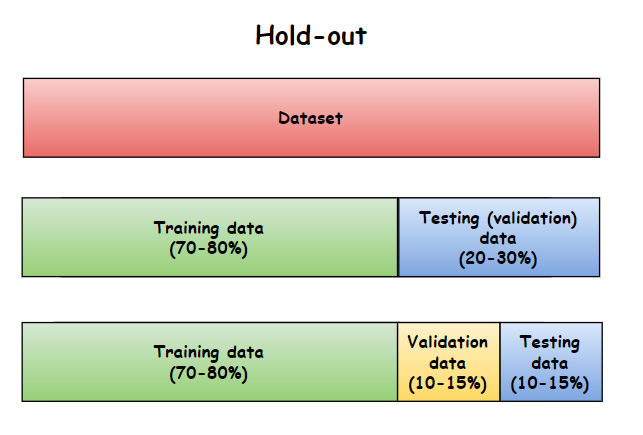

Основные параметры train_test_split():

- *arrays — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
- test_size — размер тестовой (валидационной) выборки. Может быть указан в долях. Если параметр train_size задан дробным числом с плавающей точкой, то параметр test_size определяется автоматически как 1-train_size.
- train_size — размер тренировочной выборки. Может быть указан в долях. Если параметр test_size задан дробным числом с плавающей точкой, то параметр train_size определяется автоматически как 1-test_size.
- random_state — число, на основе которого производится генерация случайных чисел.
- shuffle — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию True).
- stratify — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

In [13]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
  
## Train shape: (2620, 9)
## Valid shape: (656, 9)

Train shape: (2620, 9)
Valid shape: (656, 9)


In [15]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 
 
# Train hold-out accuracy: 0.82
# Valid hold-out accuracy: 0.77

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [17]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [18]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

## Train shape: (2620, 9)
## Valid shape: (328, 9)
## Test shape: (328, 9)

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


## k-fold

Метод k-fold более известен как кросс-валидация (cross validation), или перекрёстный контроль.

Пожалуй, это самый популярный метод валидации для оценки качества моделирования, и он используется практически во всех проектах. Эта идея также применяется во многих моделях и методах машинного обучения, например в стекинге.

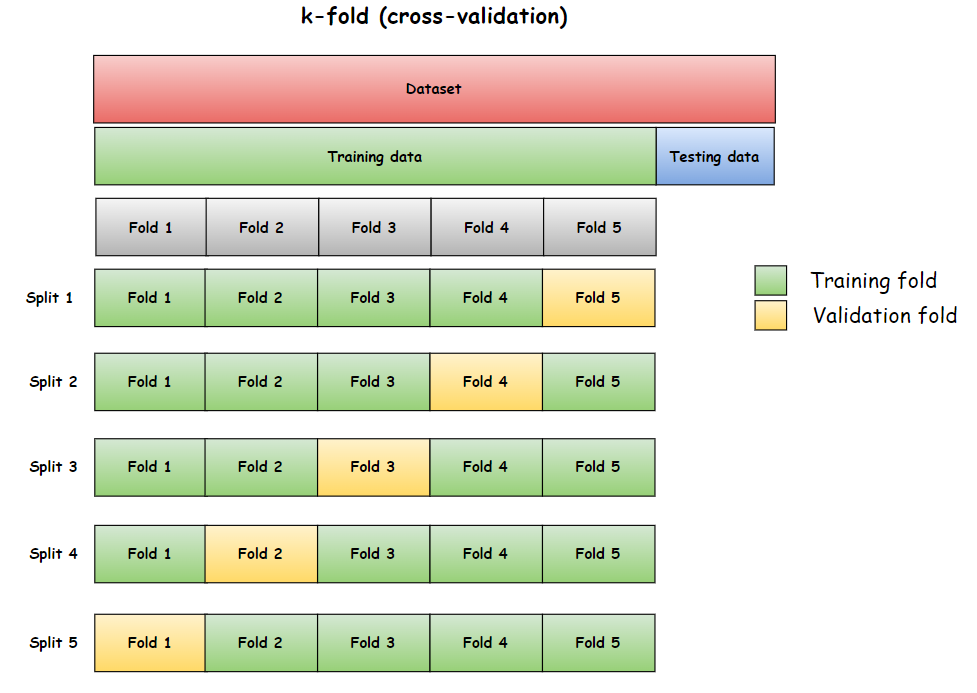

Основные параметры инициализатора KFold:

- n_split — число фолдов (число  из метода k-fold). По умолчанию — 5.
- shuffle — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
- random_state — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

In [19]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [20]:
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [21]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Основные параметры функции cross_validate():

- estimator — модель, качество которой будет проверяться на кросс-валидации.
- X — матрица наблюдений.
- y — вектор-столбец правильных ответов.
- cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
- scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
- return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

- fit_time — время обучения модели на каждой итерации кросс-валидации;
- score_time — время вычисления метрик на каждой итерации кросс-валидации;
- test_score — значения метрик на валидационных фолдах;
- train_score — значения метрик на тренировочных фолдах.

In [25]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=10)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.03911185, 0.03450775, 0.04468489, 0.04051614, 0.04163861,
        0.05120564, 0.03994536, 0.05204749, 0.03644109, 0.04014707]),
 'score_time': array([0.00299168, 0.00352788, 0.00199437, 0.00199342, 0.00594616,
        0.00227141, 0.00205016, 0.00099921, 0.00461054, 0.00199413]),
 'test_score': array([0.75      , 0.81707317, 0.7195122 , 0.75      , 0.72256098,
        0.73170732, 0.75535168, 0.69724771, 0.75535168, 0.74923547]),
 'train_score': array([0.807327  , 0.79748982, 0.81818182, 0.81546811, 0.81784261,
        0.807327  , 0.81756528, 0.81553069, 0.80874873, 0.81756528])}

In [26]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


## LEAVE-ONE-OUT

Метод leave-one-out (отложенный пример), или поэлементная кросс-валидация — это частный случай кросс-валидации (k-fold), когда размер  равняется размеру всей выборки , где  — количество примеров (строк в таблице).

Алгоритм метода:

- Повторять  раз:
  - Выбрать один случайный пример для валидации.
  - Обучить модель на всех оставшихся n-1  примерах.
  - Произвести оценку качества (вычислить метрику) на отложенном примере.
- Усреднить значение метрик на всех примерах.

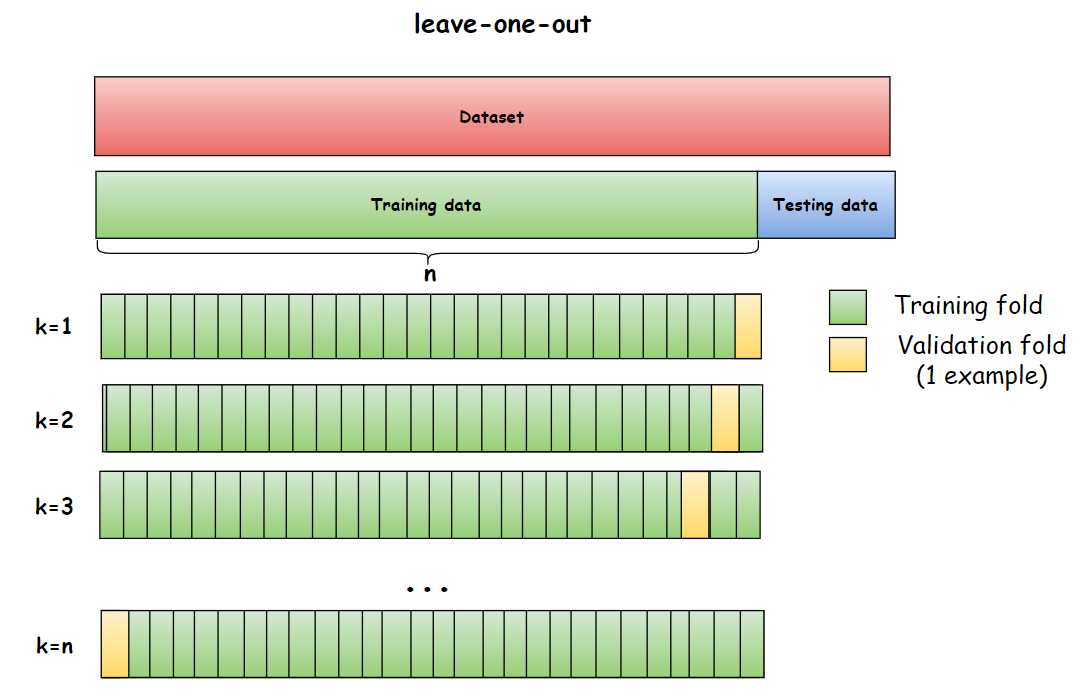

In [27]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90
